In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [82]:
trained_model = YOLO('/content/drive/MyDrive/trainedModel (full dataset)/runs/classify/train/weights/best.pt')
test_image_path = '/content/drive/MyDrive/CalEstDS/food-101-resized/bibimbap/test/1066987.jpg'

results = trained_model(test_image_path)
top1_index = results[0].probs.top1
predicted_label = results[0].names[top1_index]
confidence = results[0].probs.top1conf

print(f"Predicted: {predicted_label} ({confidence:.2%})")


image 1/1 /content/drive/MyDrive/CalEstDS/food-101-resized/bibimbap/test/1066987.jpg: 640x640 bibimbap 1.00, ramen 0.00, pho 0.00, pad_thai 0.00, spaghetti_bolognese 0.00, 8.7ms
Speed: 12.7ms preprocess, 8.7ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Predicted: bibimbap (99.88%)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


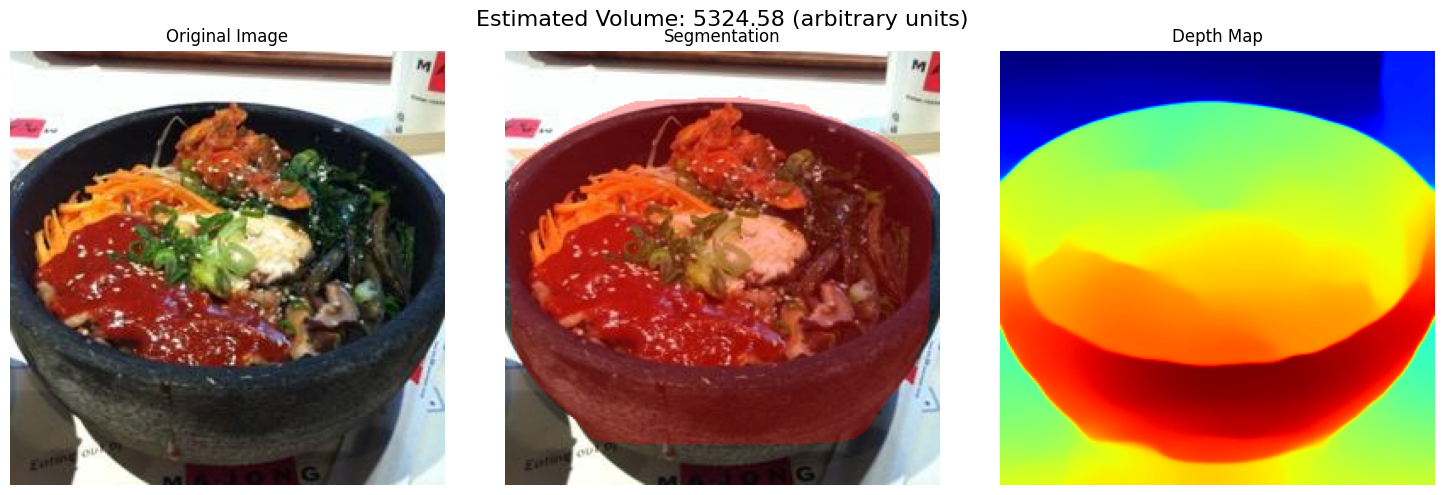

Estimated Volume: 532.46cm3


In [89]:
import numpy as np
import cv2
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob

# Load pre-trained Mask R-CNN model
def load_maskrcnn():
    model = maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    return model

# Preprocessing functions
def preprocess_midas(image, target_size=384):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(target_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(image).unsqueeze(0)

def postprocess_depth(depth):
    depth = depth.squeeze().cpu().numpy()
    return (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)

def get_segmentation_mask(model, image, original_size):
    # Preprocess image for Mask R-CNN
    img_tensor = F.to_tensor(image).unsqueeze(0)

    with torch.no_grad():
        predictions = model(img_tensor)

    # Get the first prediction
    pred = predictions[0]

    # Find the mask with highest score
    if len(pred['scores']) > 0:
        # Get highest scoring mask
        best_idx = torch.argmax(pred['scores']).item()
        mask = pred['masks'][best_idx, 0].cpu().numpy()
        mask = (mask > 0.5).astype(np.uint8)
        # Resize to original dimensions
        mask = cv2.resize(mask, original_size)
        return mask
    else:
        # Return empty mask if no objects detected
        return np.zeros(original_size[::-1], dtype=np.uint8)

def estimate_volume(seg_mask, depth_map):
    # Calculate area and average depth
    area = np.sum(seg_mask)
    if area == 0:
        return 0.0  # No food detected

    # Get depth values only in the food region
    depth_values = depth_map[seg_mask == 1]
    avg_depth = np.mean(depth_values)

    # Calculate thickness (standard deviation of depth)
    thickness = np.std(depth_values) if len(depth_values) > 0 else 0.01

    # Volume estimation formula (heuristic)
    volume = area * avg_depth * thickness
    return volume

def main(image_path):
    # Load models
    maskrcnn = load_maskrcnn()
    midas = torch.hub.load('intel-isl/MiDaS', 'DPT_Large')

    # Load image
    original_image = Image.open(image_path).convert('RGB')
    original_size = original_image.size  # (width, height)

    # Get segmentation mask
    seg_mask = get_segmentation_mask(maskrcnn, original_image, original_size)

    # Get depth estimation
    midas_input = preprocess_midas(original_image)
    with torch.no_grad():
        depth = midas(midas_input)
    depth_map = postprocess_depth(depth)
    depth_map = cv2.resize(depth_map, original_size)

    # Estimate volume
    volume = estimate_volume(seg_mask, depth_map)

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Overlay segmentation mask
    masked_image = np.array(original_image)
    masked_image[seg_mask == 1] = (masked_image[seg_mask == 1] * 0.7 +
                                  np.array([255, 0, 0]) * 0.3).astype(np.uint8)
    axes[1].imshow(masked_image)
    axes[1].set_title('Segmentation')
    axes[1].axis('off')

    axes[2].imshow(depth_map, cmap='jet')
    axes[2].set_title('Depth Map')
    axes[2].axis('off')

    plt.suptitle(f'Estimated Volume: {volume:.2f} (arbitrary units)', fontsize=16)
    plt.tight_layout()
    plt.show()

    volume = volume / 10 #from arbitrary value to approximation of cm3
    return volume

def batch_process(food_class, num_images=5):
    """Process multiple images from a food class"""
    base_path = f"/content/drive/MyDrive/CalEstDS/food-101-resized/{food_class}/test"
    images = glob.glob(os.path.join(base_path, "*.jpg"))[:num_images]

    volumes = []
    for img_path in images:
        print(f"Processing {os.path.basename(img_path)}...")
        try:
            vol = main(img_path)
            volumes.append(vol)
            print(f"Estimated Volume: {vol:.2f} arbitrary units\n")
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            volumes.append(0.0)

    return volumes

if __name__ == "__main__":
    # Mount Google Drive (if in Colab)
    if 'google.colab' in str(get_ipython()):
        from google.colab import drive
        drive.mount('/content/drive')

    # Example usage for single image
    image_path = "/content/drive/MyDrive/CalEstDS/food-101-resized/bibimbap/test/1253808.jpg"
    estimated_volume = main(image_path)
    print(f"Estimated Volume: {estimated_volume:.2f}cm3")

    # Example batch processing
    #club_volumes = batch_process("hot_dog", num_images=3)

In [90]:
import pandas as pd
import numpy as np

def estimate_calories(estimated_volume, food_name, density_df, calorie_df):
    """
    Estimate calories from volume for a given food.

    Parameters:
        volume_cm3 (float): The volume in cubic centimeters (cm^3).
        food_name (str): The name of the food item.
        density_df (pd.DataFrame): DataFrame with columns ['food', 'density_g_per_cm3'].
        calorie_df (pd.DataFrame): DataFrame with columns ['food', 'weight_g', 'calories'].

    Returns:
        Estimated calories (float).
    """
    # Ensure food exists in density data
    if food_name not in density_df['food'].values:
        raise ValueError(f"Food '{food_name}' not found in density data.")

    # Get density
    density = density_df.loc[density_df['food'] == food_name, 'density_g_per_cm3'].iloc[0]

    # Estimate weight
    estimated_weight = estimated_volume * density

    # Filter calorie_df for this food
    food_calorie_data = calorie_df[calorie_df['food'] == food_name]

    if food_calorie_data.empty:
        raise ValueError(f"Calorie data not available for food: {food_name}")

    first_row = food_calorie_data.iloc[0]
    cal_per_gram = first_row['calories'] / first_row['weight_g']

    calories = estimated_weight * density
    return calories, estimated_weight, density

#Example usage:
# density_df = pd.read_csv("densities.csv")
# calorie_df = pd.read_csv("calories_by_weight.csv")
# volume = estimated_volume  # cm^3, for example
# food = predicted_label
# calories = estimate_calories(volume, food, density_df, calorie_df)
# print(f"Estimated calories: {calories:.1f} kcal")

In [91]:
density_df = pd.read_csv("/content/drive/MyDrive/Project - Calorie Estimation/density_df.csv")
calorie_df = pd.read_csv("/content/drive/MyDrive/Project - Calorie Estimation/calorie_df.csv")
volume = estimated_volume  # cm^3, for example
print(f"Estimated volume: {volume:.1f} ")
food = predicted_label
print(f"Esimated food: {food}")
calories, estimated_weight, density = estimate_calories(volume, food, density_df, calorie_df)
print(f"Estimated calories: {calories:.1f} kcal")
weight = estimated_weight
print(f"Estimated weight: {weight:.1f}")
print(f"Estimated density: {density:.1f}")

Estimated volume: 532.5 
Esimated food: bibimbap
Estimated calories: 779.6 kcal
Estimated weight: 644.3
Estimated density: 1.2


In [93]:
from PIL import Image, ImageDraw, ImageFont

img = Image.open("/content/drive/MyDrive/CalEstDS/food-101-resized/bibimbap/test/1253808.jpg")
draw = ImageDraw.Draw(img)

try:
    font = ImageFont.truetype("arial.ttf", size=24)
except:
    font = ImageFont.load_default()

text = f"{predicted_label}: {calories:.1f} kcal"
print(text)
position = (10, 10)  # top-left with small padding
draw.text(position, text, fill="black", font=font)

text2 = f"Volume = {volume:.1f}cm3, Weight = {weight:.1f}g"
print(text2)
position = (10, 20)  # top-left with small padding
draw.text(position, text2, fill="black", font=font)

img.save("output_with_label.jpg")
img.show()

bibimbap: 779.6 kcal
Volume = 532.5cm3, Weight = 644.3g
